In [50]:
import numpy as np
import pandas as pd 
import torch 
import matplotlib.pyplot as plt 

In [51]:
import os 
os.chdir('/kaggle/input/data-diff') #Define Data Directory

In [56]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

class SuperresDataset(Dataset):
    def __init__(self, hr_images, lr_images, max_images=None):
        """
        Initialize the SuperresDataset.

        Parameters:
        - hr_images (list of ndarray): High-resolution images.
        - lr_images (list of ndarray): Low-resolution images.
        - max_images (int, optional): Maximum number of images to use.
        """
        self.hr_images = [torch.tensor(img, dtype=torch.float32) for img in hr_images]
        self.lr_images = [torch.tensor(img, dtype=torch.float32) for img in lr_images]
        
        if max_images is not None:
            self.hr_images = self.hr_images[:max_images]
            self.lr_images = self.lr_images[:max_images]
        
    def __len__(self):
        return len(self.hr_images)

    def __getitem__(self, idx):
        """
        Get the interpolated low-resolution image and high-resolution image at the specified index.

        Parameters:
        - idx (int): Index of the image to retrieve.

        Returns:
        - tuple of torch.Tensor: Interpolated low-resolution image and high-resolution image.
        """
        hr = self.hr_images[idx]
        lr = self.lr_images[idx]
        
        # Ensure LR and HR images are 4D (N, C, H, W) for interpolation
        if len(lr.shape) == 2:  # If single channel 2D image
            lr = lr.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
            hr = hr.unsqueeze(0).unsqueeze(0)
        elif len(lr.shape) == 3:  # If 3D (C, H, W) image
            lr = lr.unsqueeze(0)
            hr = hr.unsqueeze(0)
        
        # Interpolate LR image to the size of HR image
        lr_interpolated = F.interpolate(lr, size=hr.shape[2:], mode='bilinear', align_corners=False)
        
        return lr_interpolated.squeeze(0), hr.squeeze(0)

In [57]:
hr_images = np.load('HR_new.npy')
lr_images = np.load('LR_new.npy')

In [58]:
import numpy as np
import torch
from torch.utils.data import DataLoader

total_samples = len(hr_images)
train_size = int(0.90 * total_samples)
test_size = total_samples - train_size
indices = np.arange(total_samples)
np.random.shuffle(indices)
train_indices, test_indices = indices[:train_size], indices[train_size:]

train_dataset = SuperresDataset([hr_images[i] for i in train_indices], [lr_images[i] for i in train_indices])
test_dataset = SuperresDataset([hr_images[i] for i in test_indices], [lr_images[i] for i in test_indices])

batch_size = 16
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Forward Process

In [62]:
import torch
import numpy as np
import torch.nn.functional as F

def cosine_beta_schedule(timesteps, s=0.008):
    steps = torch.arange(timesteps, dtype=torch.float32) / timesteps
    cosine_schedules = torch.cos(((steps + s) / (1 + s)) * np.pi * 0.5)
    betas = 1 - cosine_schedules**2
    return betas.clamp(min=0.0001, max=0.9999)


def forward_diffusion_sample(x_0, t, device="cpu"):
    noise = torch.randn_like(x_0)   
    sqrt_alphas_cumprod_t = get_index_from_list(sqrt_alphas_cumprod, t, x_0.shape)
    sqrt_one_minus_alphas_cumprod_t = get_index_from_list(sqrt_one_minus_alphas_cumprod, t, x_0.shape)
    return sqrt_alphas_cumprod_t.to(device) * x_0.to(device) + sqrt_one_minus_alphas_cumprod_t.to(device) * noise.to(device), noise.to(device)

def get_index_from_list(vals, t, x_shape):
    batch_size = t.shape[0]
    out = vals.gather(-1, t.cpu())
    return out.reshape(batch_size, *((1,) * (len(x_shape) - 1))).to(t.device)

T = 1000
betas = cosine_beta_schedule(T)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, dim=0)
alphas_cumprod_prev = F.pad(alphas_cumprod[:-1], (1, 0), value=1.0)
sqrt_recip_alphas = torch.sqrt(1.0 / alphas)
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1. - alphas_cumprod)
posterior_variance = betas * (1. - alphas_cumprod_prev) / (1. - alphas_cumprod)

# UNet Model 

In [63]:
import torch
from torch import nn
import math

class Block(nn.Module):
    def __init__(self, in_ch, out_ch, time_emb_dim, up=False):
        super().__init__()
        self.time_mlp = nn.Linear(time_emb_dim, out_ch)
        if up:
            self.conv1 = nn.Conv2d(2 * in_ch, out_ch, 3, padding=1)
            self.transform = nn.ConvTranspose2d(out_ch, out_ch, 4, 2, 1)
        else:
            self.conv1 = nn.Conv2d(in_ch, out_ch, 3, padding=1)
            self.transform = nn.Conv2d(out_ch, out_ch, 4, 2, 1)
        self.conv2 = nn.Conv2d(out_ch, out_ch, 3, padding=1)
        self.bnorm1 = nn.BatchNorm2d(out_ch)
        self.bnorm2 = nn.BatchNorm2d(out_ch)
        self.relu = nn.ReLU()
        
    def forward(self, x, t):
        h = self.bnorm1(self.relu(self.conv1(x)))
        time_emb = self.relu(self.time_mlp(t))
        time_emb = time_emb[(..., ) + (None, ) * 2]
        h = h + time_emb
        h = self.bnorm2(self.relu(self.conv2(h)))
        return self.transform(h)

class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

class SimpleUnet(nn.Module):
    def __init__(self):
        super().__init__()
        image_channels = 1
        down_channels = (64, 128, 256, 512, 1024)
        up_channels = (1024, 512, 256, 128, 64)
        out_dim = 1 
        time_emb_dim = 32
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, time_emb_dim),
            nn.ReLU()
        )
        self.conv0 = nn.Conv2d(image_channels, down_channels[0], 3, padding=1)
        self.downs = nn.ModuleList([Block(down_channels[i], down_channels[i + 1], time_emb_dim) for i in range(len(down_channels) - 1)])
        self.ups = nn.ModuleList([Block(up_channels[i], up_channels[i + 1], time_emb_dim, up=True) for i in range(len(up_channels) - 1)])
        self.output = nn.Conv2d(up_channels[-1], out_dim, 1)

    def forward(self, x, timestep):
        t = self.time_mlp(timestep)
        x = self.conv0(x)
        residual_inputs = []
        for down in self.downs:
            x = down(x, t)
            residual_inputs.append(x)
        for up in self.ups:
            residual_x = residual_inputs.pop()
            x = torch.cat((x, residual_x), dim=1)
            x = up(x, t)
        return self.output(x)

In [65]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [66]:
model = SimpleUnet().to(device)    
model.to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs!")
    model = nn.DataParallel(model)

Using 2 GPUs!


In [ ]:
import torch
from torch.optim import AdamW
from torch.nn import L1Loss
from tqdm import tqdm

def train_model(model, dataloader, optimizer, criterion, device, T, epochs=20):
    """
    Trains the model using the given dataloader, optimizer, and criterion.

    Parameters:
    - model (nn.Module): The model to train.
    - dataloader (DataLoader): The dataloader for training data.
    - optimizer (torch.optim.Optimizer): The optimizer for training.
    - criterion (nn.Module): The loss function.
    - device (str): Device to perform training on.
    - T (int): Number of timesteps.
    - epochs (int): Number of training epochs.
    """
    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        with tqdm(total=len(dataloader), desc=f"Epoch {epoch+1}/{epochs}") as pbar:
            for step, (lr, hr) in enumerate(dataloader):
                lr, hr = lr.to(device), hr.to(device)
                optimizer.zero_grad()
                timesteps = torch.randint(0, T, (lr.size(0),), device=device).long()
                predicted_hr = model(lr, timesteps)
                loss = criterion(predicted_hr, hr)
                loss.backward()
                optimizer.step()
                running_loss += loss.item()
                pbar.set_postfix(loss=running_loss / (step + 1))
                pbar.update(1)
        print(f"End of Epoch {epoch+1} | Loss: {running_loss / len(dataloader):.8f}")

# Example usage
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
unet_model = SimpleUnet().to(device)
optimizer = AdamW(unet_model.parameters(), lr=1e-6)
criterion = L1Loss()
train_model(unet_model, train_loader, optimizer, criterion, device, T, epochs=20)

Epoch 1/20: 100%|██████████| 638/638 [01:36<00:00,  6.58it/s, loss=0.0135]


End of Epoch 0 | Loss: 0.01352730


Epoch 2/20: 100%|██████████| 638/638 [01:36<00:00,  6.60it/s, loss=0.0134]


End of Epoch 1 | Loss: 0.01338061


Epoch 3/20: 100%|██████████| 638/638 [01:35<00:00,  6.68it/s, loss=0.0133]


End of Epoch 2 | Loss: 0.01329018


Epoch 4/20: 100%|██████████| 638/638 [01:36<00:00,  6.64it/s, loss=0.0132]


End of Epoch 3 | Loss: 0.01322338


Epoch 5/20: 100%|██████████| 638/638 [01:35<00:00,  6.69it/s, loss=0.0132]


End of Epoch 4 | Loss: 0.01317691


Epoch 6/20: 100%|██████████| 638/638 [01:35<00:00,  6.68it/s, loss=0.0131]


End of Epoch 5 | Loss: 0.01313650


Epoch 7/20: 100%|██████████| 638/638 [01:35<00:00,  6.68it/s, loss=0.0131]


End of Epoch 6 | Loss: 0.01310192


Epoch 8/20: 100%|██████████| 638/638 [01:35<00:00,  6.69it/s, loss=0.0131]


End of Epoch 7 | Loss: 0.01307586


Epoch 9/20: 100%|██████████| 638/638 [01:35<00:00,  6.67it/s, loss=0.0131]


End of Epoch 8 | Loss: 0.01305249


Epoch 10/20: 100%|██████████| 638/638 [01:35<00:00,  6.68it/s, loss=0.013] 


End of Epoch 9 | Loss: 0.01303401


Epoch 11/20: 100%|██████████| 638/638 [01:35<00:00,  6.68it/s, loss=0.013] 


End of Epoch 10 | Loss: 0.01301289


Epoch 12/20: 100%|██████████| 638/638 [01:37<00:00,  6.56it/s, loss=0.013] 


End of Epoch 11 | Loss: 0.01299710


Epoch 13/20: 100%|██████████| 638/638 [01:38<00:00,  6.48it/s, loss=0.013] 


End of Epoch 12 | Loss: 0.01298592


Epoch 14/20: 100%|██████████| 638/638 [01:37<00:00,  6.51it/s, loss=0.013] 


End of Epoch 13 | Loss: 0.01297137


Epoch 15/20: 100%|██████████| 638/638 [01:37<00:00,  6.52it/s, loss=0.013] 


End of Epoch 14 | Loss: 0.01296042


Epoch 16/20: 100%|██████████| 638/638 [01:36<00:00,  6.60it/s, loss=0.0129]


End of Epoch 15 | Loss: 0.01294599


Epoch 17/20:  64%|██████▍   | 408/638 [01:01<00:35,  6.44it/s, loss=0.0131]

In [ ]:
torch.save(model.state_dict(), '/kaggle/working/ddpm_real2.pth') #Save Model

In [67]:
model_path = '/kaggle/working/ddpm_real2.pth'
model.load_state_dict(torch.load(model_path, map_location=device)) #Load Model

<All keys matched successfully>

In [68]:
import torch
import numpy as np
from torch import nn
from skimage.metrics import structural_similarity

def calculate_psnr(img1, img2):
    mse = nn.functional.mse_loss(img1, img2)
    return 20 * torch.log10(1.0 / torch.sqrt(mse))

def calculate_ssim(img1, img2, data_range=1.0, win_size=11):
    img1 = img1.squeeze().cpu().numpy()
    img2 = img2.squeeze().cpu().numpy()
    return structural_similarity(img1, img2, win_size=win_size, data_range=data_range, multichannel=False)

def evaluate_model(model, dataloader, win_size=11, data_range=1.0):
    model.eval()
    mse_lr_hr = 0.0
    mse_lr_predhr = 0.0
    mse_hr_predhr = 0.0
    psnr_lr_hr = 0.0
    psnr_lr_predhr = 0.0
    psnr_hr_predhr = 0.0
    ssim_lr_hr = 0.0
    ssim_lr_predhr = 0.0
    ssim_hr_predhr = 0.0
    num_samples = 0

    with torch.no_grad():
        for step, (lr, hr) in enumerate(dataloader):
            lr, hr = lr.to(device), hr.to(device)
            timesteps = torch.randint(0, T, (lr.size(0),), device=device).long()
            predicted_hr = model(lr, timesteps)

            # Loop over each image in the batch
            batch_size = lr.size(0)
            for i in range(batch_size):
                mse_lr_hr += nn.MSELoss()(lr[i], hr[i]).item()
                mse_lr_predhr += nn.MSELoss()(lr[i], predicted_hr[i]).item()
                mse_hr_predhr += nn.MSELoss()(hr[i], predicted_hr[i]).item()

                psnr_lr_hr += calculate_psnr(lr[i], hr[i])
                psnr_lr_predhr += calculate_psnr(lr[i], predicted_hr[i])
                psnr_hr_predhr += calculate_psnr(hr[i], predicted_hr[i])

                ssim_lr_hr += calculate_ssim(lr[i], hr[i], data_range, win_size)
                ssim_lr_predhr += calculate_ssim(lr[i], predicted_hr[i], data_range, win_size)
                ssim_hr_predhr += calculate_ssim(hr[i], predicted_hr[i], data_range, win_size)

                num_samples += 1

    mse_lr_hr /= num_samples
    mse_lr_predhr /= num_samples
    mse_hr_predhr /= num_samples
    psnr_lr_hr /= num_samples
    psnr_lr_predhr /= num_samples
    psnr_hr_predhr /= num_samples
    ssim_lr_hr /= num_samples
    ssim_lr_predhr /= num_samples
    ssim_hr_predhr /= num_samples

    print(f"Avg MSE (LR, HR): {mse_lr_hr:.8f}")
    print(f"Avg MSE (LR, Predicted HR): {mse_lr_predhr:.8f}")
    print(f"Avg MSE (HR, Predicted HR): {mse_hr_predhr:.8f}")
    print(f"Avg PSNR (LR, HR): {psnr_lr_hr:.8f}")
    print(f"Avg PSNR (LR, Predicted HR): {psnr_lr_predhr:.8f}")
    print(f"Avg PSNR (HR, Predicted HR): {psnr_hr_predhr:.8f}")
    print(f"Avg SSIM (LR, HR): {ssim_lr_hr:.8f}")
    print(f"Avg SSIM (LR, Predicted HR): {ssim_lr_predhr:.8f}")
    print(f"Avg SSIM (HR, Predicted HR): {ssim_hr_predhr:.8f}")

evaluate_model(model, test_dataloader)


Avg MSE (LR, HR): 0.04013780
Avg MSE (LR, Predicted HR): 0.02391108
Avg MSE (HR, Predicted HR): 0.00708162
Avg PSNR (LR, HR): 17.05854607
Avg PSNR (LR, Predicted HR): 17.71502113
Avg PSNR (HR, Predicted HR): 26.95506859
Avg SSIM (LR, HR): 0.55897684
Avg SSIM (LR, Predicted HR): 0.62531825
Avg SSIM (HR, Predicted HR): 0.82158774


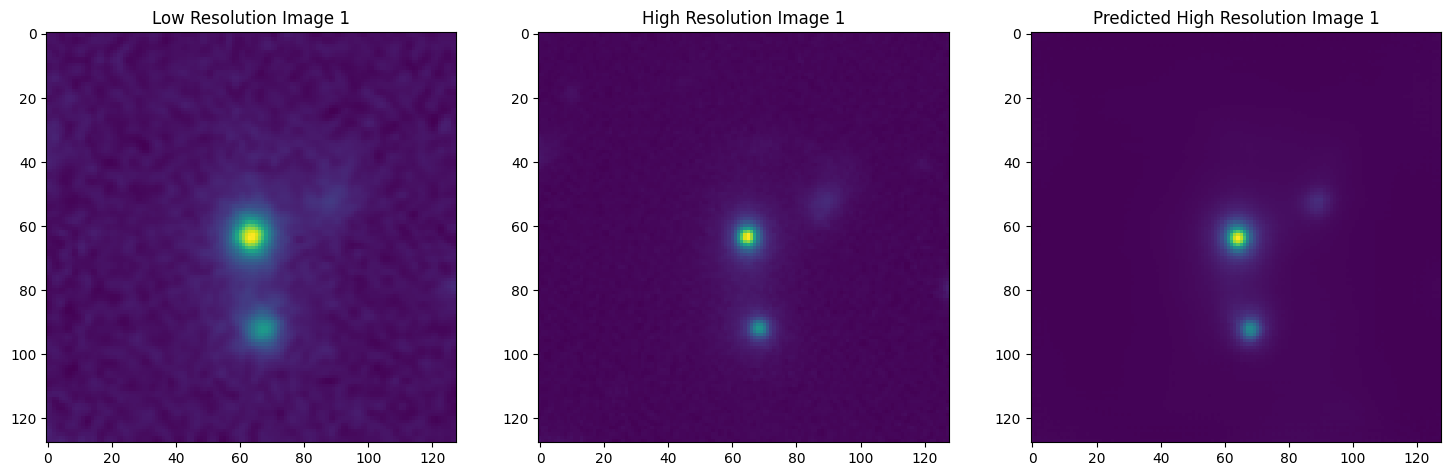

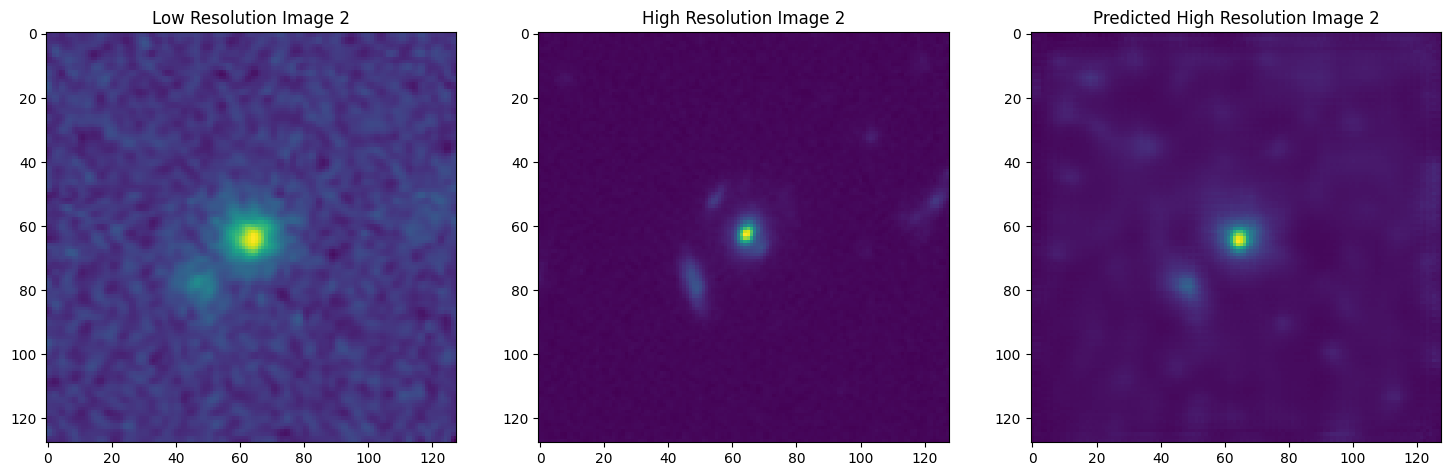

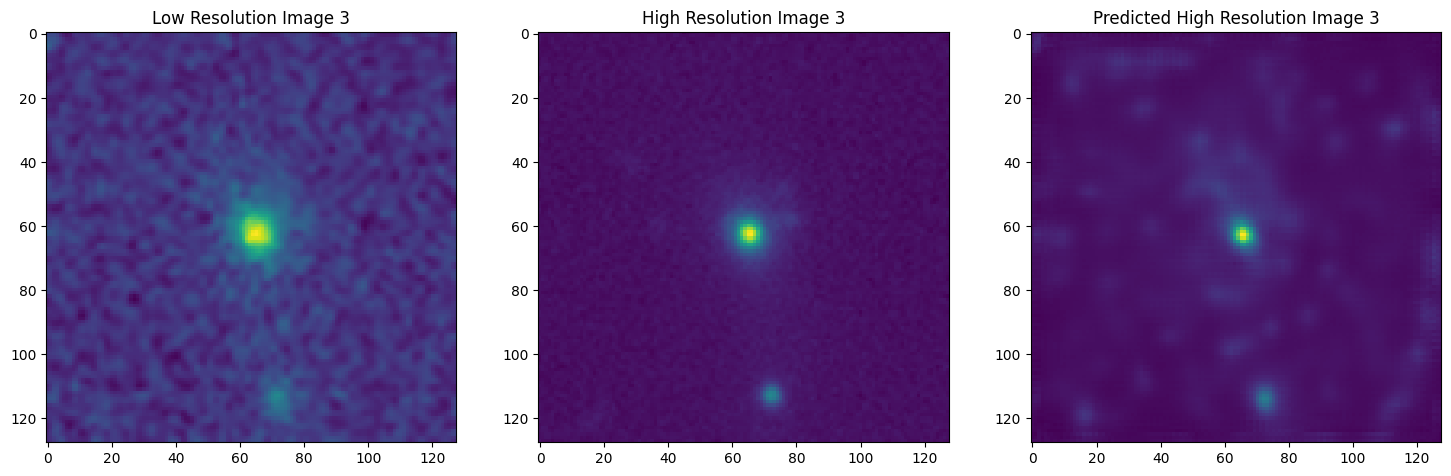

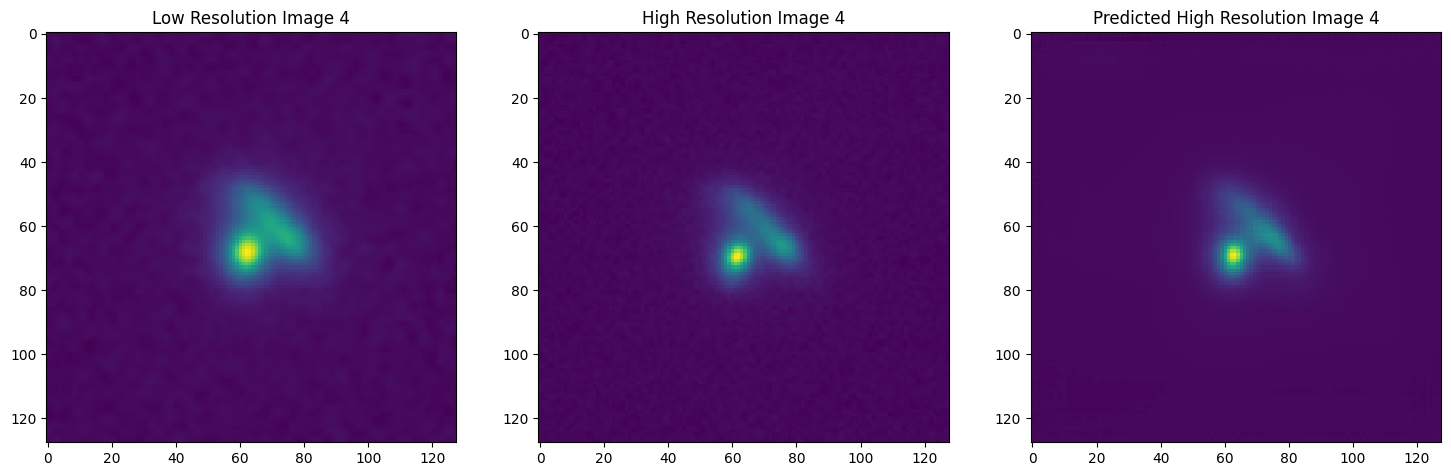

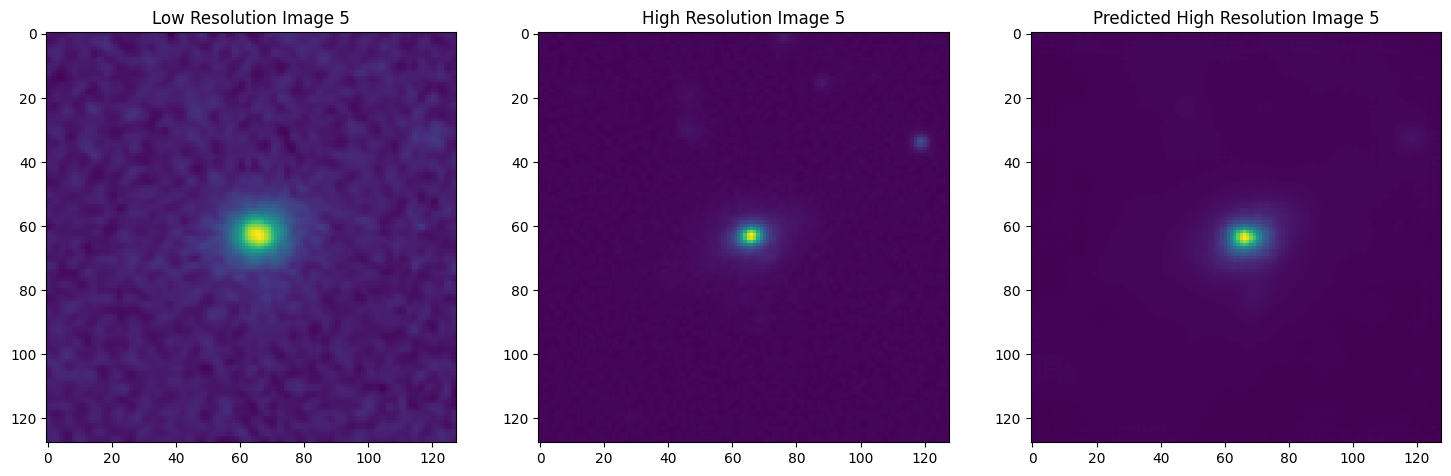

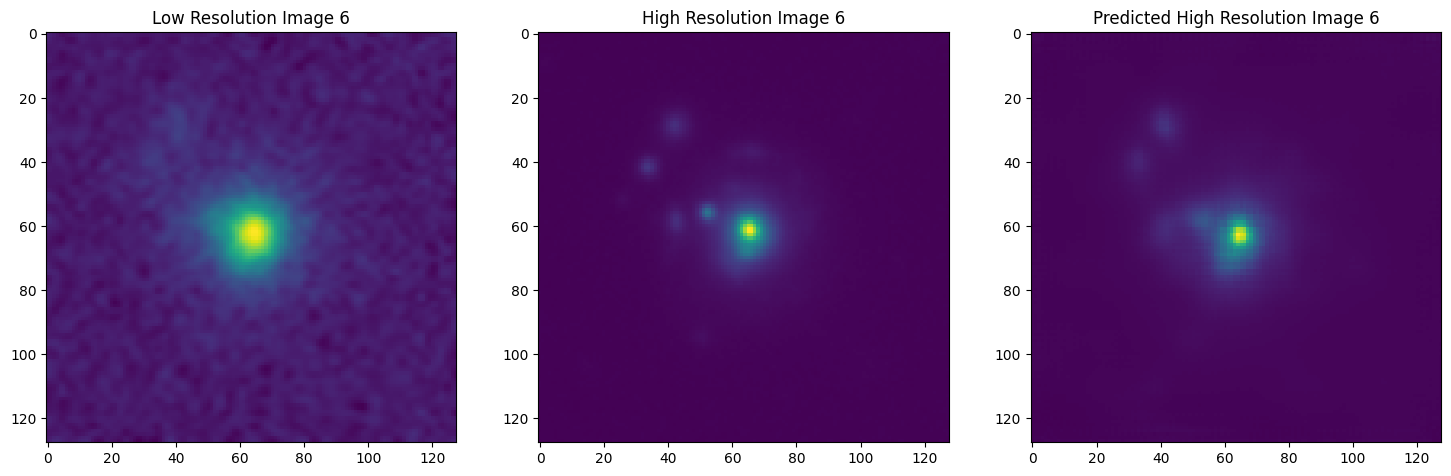

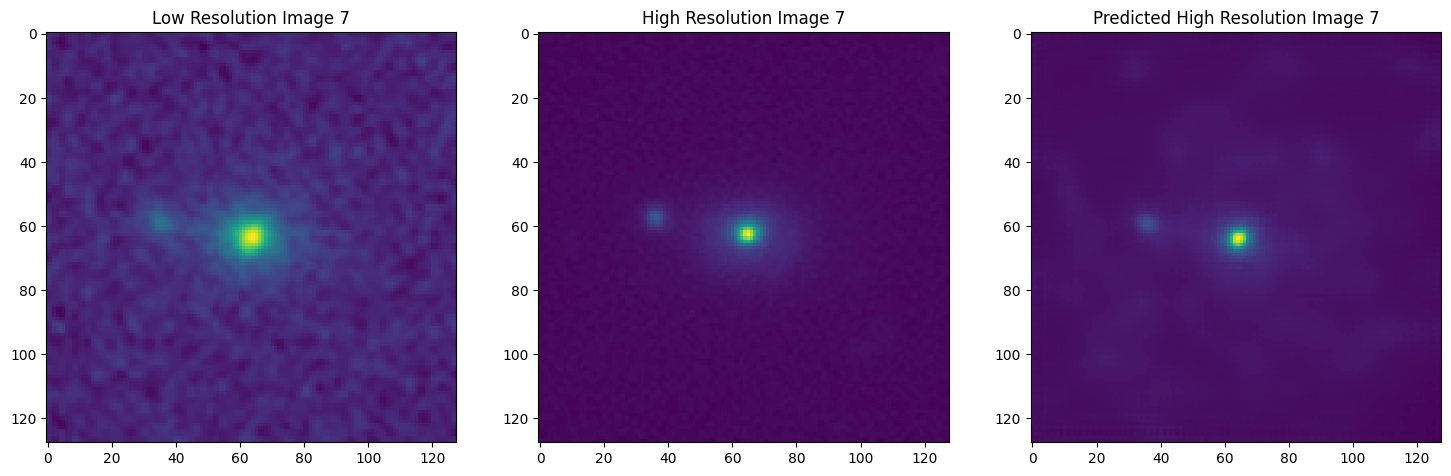

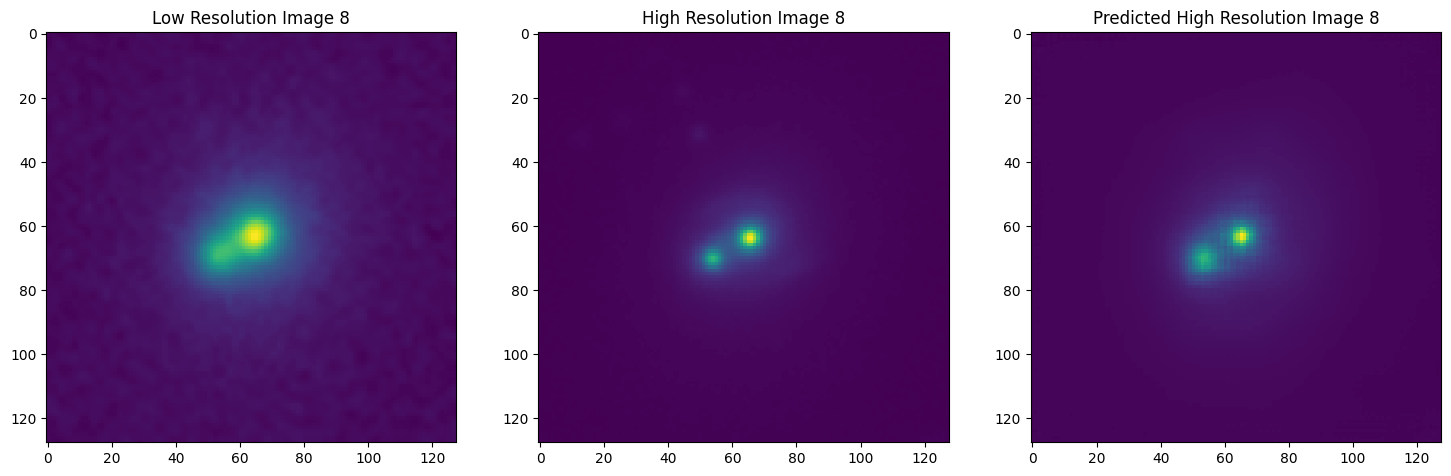

In [69]:
import matplotlib.pyplot as plt

model.eval()

for i, (lr_batch, hr_batch) in enumerate(test_dataloader):
    if i >= 2:  
        break

    lr_batch, hr_batch = lr_batch.to(device), hr_batch.to(device)
    
    timesteps = torch.randint(0, 1000, (lr_batch.size(0),), device=device).long()
    with torch.no_grad():
        pred_hr_batch = model(lr_batch, timesteps)
    
    lr_batch = lr_batch.cpu().detach()
    hr_batch = hr_batch.cpu().detach()
    pred_hr_batch = pred_hr_batch.cpu().detach()
    
    for j in range(lr_batch.size(0)):  # Iterate through each image in the batch
        lr = lr_batch[j].squeeze()
        hr = hr_batch[j].squeeze()
        pred_hr = pred_hr_batch[j].squeeze()
        
        plt.figure(figsize=(18, 6))
        
        plt.subplot(1, 3, 1)
        plt.imshow(lr, cmap='viridis')
        plt.title(f'Low Resolution Image {i*lr_batch.size(0) + j + 1}')
        
        plt.subplot(1, 3, 2)
        plt.imshow(hr, cmap='viridis')
        plt.title(f'High Resolution Image {i*lr_batch.size(0) + j + 1}')
        
        plt.subplot(1, 3, 3)
        plt.imshow(pred_hr, cmap='viridis')
        plt.title(f'Predicted High Resolution Image {i*lr_batch.size(0) + j + 1}')
        
        plt.show()
